In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import json
import os

In [6]:
df = pd.read_csv('../data/reviews.csv')
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEcWS_b8b4P2gClKovxXAPg3il0AD0ZnGw9RxY...,H G,https://play-lh.googleusercontent.com/-2Zyc1Oz...,Unable to use it as it won't work with my Goog...,1,13,5.7.0.20,2021-01-11 01:12:58,"As our team explained profusely, we sync data ...",2021-01-10 12:58:09,most_relevant,com.anydo
1,gp:AOqpTOEidRmDaHGYPZW21SVfBkeqTruAzg7LAmCPL2_...,Michelle Armstrong,https://play-lh.googleusercontent.com/a-/AOh14...,I downloaded this because of the cross platfor...,1,81,5.7.0.20,2020-12-22 18:31:11,The Premium ad only shows up when first openin...,2020-12-23 19:58:46,most_relevant,com.anydo
2,gp:AOqpTOEJfVU5Os7_8CNOu_mpy2AlDz8kFxEFMeBMnxC...,Yiğitcan Sümbelli,https://play-lh.googleusercontent.com/a-/AOh14...,I am starting to hate this app! Every time the...,1,67,5.7.0.10,2020-12-02 15:52:24,"Hi, please note that these issues usually are ...",2020-12-03 20:47:02,most_relevant,com.anydo
3,gp:AOqpTOFSPaoOVarqwKF86e7-TPUyV6BanSXKRNFGb6G...,Jon Pember,https://play-lh.googleusercontent.com/-97UNn5D...,"Liked Any.do at first, enough that I even sign...",1,102,5.7.0.10,2020-11-22 23:42:56,Please note that Any.do integrates directly wi...,2020-11-25 13:30:01,most_relevant,com.anydo
4,gp:AOqpTOEmghRiCCy0_FYbWBSoRm2ff2hzFTbEjgQ9svu...,Harry Wexler Jr. MBA,https://play-lh.googleusercontent.com/a-/AOh14...,They made me sign up for premium just to have ...,1,2,5.7.0.20,2020-12-31 01:49:52,"We never require users to upgrade, as 90% of t...",2020-12-31 20:40:53,most_relevant,com.anydo


In [7]:
df.shape

(16388, 12)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16388 entries, 0 to 16387
Data columns (total 12 columns):
reviewId                16388 non-null object
userName                16388 non-null object
userImage               16388 non-null object
content                 16388 non-null object
score                   16388 non-null int64
thumbsUpCount           16388 non-null int64
reviewCreatedVersion    14028 non-null object
at                      16388 non-null object
replyContent            8488 non-null object
repliedAt               8488 non-null object
sortOrder               16388 non-null object
appId                   16388 non-null object
dtypes: int64(2), object(10)
memory usage: 1.5+ MB


We have 16k examples, and we will focus on the content and score items. Luckily there isn't any missing value in these columns. Then let's check if these data is balance.

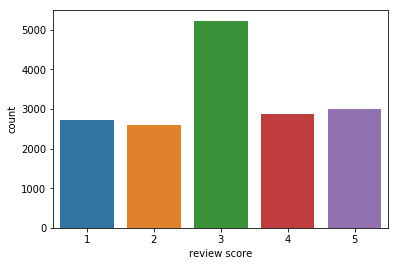

In [9]:
sns.countplot(df.score)
plt.xlabel('review score')
plt.show()

It looks like these data are very imbalance. So, i'll convert these scores into negative, netural and positive classes.

In [10]:
def convert(item):
    if item < 3:
        return 'negative'
    elif item == 3:
        return 'netural'
    else:
        return 'positve'

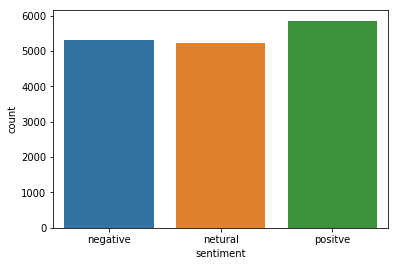

In [11]:
df['sentiment'] = df.score.apply(convert)
sns.countplot(df.sentiment)
plt.show()

After the convertion, the data imbalance issue has been solved. Let's check the length distribution of the contents.

In [12]:
content_len = list()
for i in df.content:
    content_len.append(len(i))

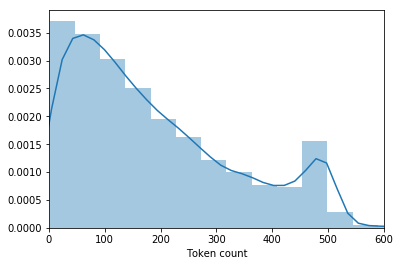

The average length of these tokens is 192.806321698804, the max length of these tokens is 2264


In [13]:
sns.distplot(content_len)
plt.xlim([0,600])
plt.xlabel('Token count')
plt.show()
print(f"The average length of these tokens is {np.mean(np.array(content_len))}, the max length of these tokens is {max(content_len)}")

In [14]:
def find_outliers(length,content_list):
    cnt = 0
    for content in content_list:
        if content > length:
            cnt += 1
    return cnt

In [15]:
length = 200
print(f"if i set the max sequence length to {length}, {find_outliers(length,content_len)/len(content_len)*100}% data will be truncated")

if i set the max sequence length to 200, 38.64412985111057% data will be truncated


I'll set the max seqence length of the bert model to 200. This number will be modify if the performance of the model can't meet my requirements.

## Train Test Split

In [ ]:
train = list()
test = list()
val = list()

In [ ]:
idx = df.groupby('sentiment').apply(lambda x: x.sample(frac=0.8,random_state=0)).index.get_level_values(1)
train = df.iloc[idx,:].reset_index(drop=True)
test = df.drop(idx).reset_index(drop=True)
idx2 = test.groupby('sentiment').apply(lambda x: x.sample(frac=0.5, random_state=0)).index.get_level_values(1)
val = test.iloc[idx2,:].reset_index(drop=True)
test = test.drop(idx2).reset_index(drop=True)

In [ ]:
train = [{'text':k,'label':[v]} for k,v in zip(train['content'], train['sentiment'])]
test = [{'text':k,'label':[v]} for k,v in zip(test['content'], test['sentiment'])]
val = [{'text':k,'label':[v]} for k,v in zip(val['content'], val['sentiment'])]

In [ ]:
def generate_file(data,name):
    data_dir = '../data'
    f = open(os.path.join(data_dir,name),'w')
    for i in data:
        print(json.dumps(i,ensure_ascii=False),file = f)
    f.close()

In [ ]:
file = [(train,'train'),(test,'test'),(val,'val')]
for i in file:
    generate_file()

In [34]:
idx = df.groupby('sentiment').apply(lambda x: x.sample(frac=0.8,random_state=0)).index.get_level_values(1)
train = df.iloc[idx,:].reset_index(drop=True)
test = df.drop(idx).reset_index(drop=True)
idx2 = test.groupby('sentiment').apply(lambda x: x.sample(frac=0.5, random_state=0)).index.get_level_values(1)
val = test.iloc[idx2,:].reset_index(drop=True)
test = test.drop(idx2).reset_index(drop=True)

In [40]:
train = [{'text':k,'label':[v]} for k,v in zip(train['content'], train['sentiment'])]
test = [{'text':k,'label':[v]} for k,v in zip(test['content'], test['sentiment'])]
val = [{'text':k,'label':[v]} for k,v in zip(val['content'], val['sentiment'])]

In [51]:
def generate_file(data,name):
    data_dir = '../data'
    name = name+'.json'
    f = open(os.path.join(data_dir,name),'w')
    for i in data:
        print(json.dumps(i,ensure_ascii=False),file = f)
    f.close()

In [52]:
file = [(train,'train'),(test,'test'),(val,'val')]
for i in file:
    generate_file(i[0],i[1])